In [1]:
import sklearn
import graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.tree
import numpy as np
import urllib
import csv
import string
import pandas as pd
from StringIO import StringIO
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from datetime import datetime
from sklearn.feature_selection import RFE
from sklearn.utils import shuffle


DATA CLEANING for Lending Club data

In [2]:
#read data
LCdata = pd.read_csv(open("C:\Users\Ashrita\Documents\Machine Learning\Project Files\Individual Projects\LendingClub2012to2013.csv"), header=0, index_col=False, low_memory=False)
#just checking data is loaded
print(LCdata.shape)

#removing "_" from Header names
LCdata.columns=pd.Series(list(LCdata.columns.values)).str.replace('_', '')
original_headers = list(LCdata.columns.values)

#Remove columns that have all NAs
LCdata=LCdata.dropna(axis=1, how='all', thresh=None, subset=None, inplace=False)
print "Dataset size after removing columns that have all NAs"
print(LCdata.shape)

LCdata.intrate = pd.Series(LCdata.intrate).str.replace('%', '').astype(float)
LCdata['emplength'].replace('n/a', np.nan, inplace=True)
LCdata.emplength.fillna(value=0, inplace=True)
LCdata['emplength'].replace(to_replace='[^0-9]+',value='',inplace=True,regex=True)
LCdata['emplength']=LCdata['emplength'].astype(int)
LCdata.revolutil = pd.Series(LCdata.revolutil).str.replace('%', '').astype(float)
LCdata.earliestcrline = pd.to_datetime(LCdata.earliestcrline)
dttoday = datetime.now().strftime('%Y-%m-%d')
LCdata.earliestcrline = LCdata.earliestcrline.apply(lambda x: (
        np.timedelta64((x - pd.Timestamp(dttoday)),'D').astype(int))/-365)

LCdata['term'].replace(to_replace='[^0-9]+',value='',inplace=True,regex=True)
LCdata['term']=LCdata['term'].astype(int)

(188181, 115)
Dataset size after removing columns that have all NAs
(188181, 98)


In [3]:
#Checking the values of Emptitle 
print LCdata.emptitle.value_counts().tail()
#Dropping URL, Desc,Emptitle,id,member columns since they are inputs from customers and values are diverse and hence wouldnt contribute to the 
#Prediction analysis
LCdata.drop(['url','desc','emptitle','id', 'memberid','applicationtype'], 1, inplace=True)
print(LCdata.shape)

238 green corp                          1
town motors                             1
Jumma Inc                               1
Tiburcio Vasquez Health Center, Inc.    1
Elmsford Union Free School District     1
Name: emptitle, dtype: int64
(188181, 92)


Target Leakage

In [4]:
LCdata.drop(['collectionrecoveryfee', 'grade', 'intrate', 'issued', 'lastcreditpulld', 'lastpymntamnt', 'lastpymntd',
            'nextpymntd', 'outprncp', 'outprncpinv', 'subgrade', 'totalpymnt','totalpymntinv','totalrecint', 
             'totalreclatefee', 'totalrecprncp', 'recoveries', 'verificationstatus','pymntplan'], 1, inplace = True)
print(LCdata.shape)

(188181, 73)


In [5]:
print LCdata.columns[LCdata.isnull().mean() > 0.7]
#Deleting columns that have more than 70% Null values
LCdata.drop(['mthssincelastrecord', 'mthssincelastmajorderog', 'mthssincerecentbcdlq','mthssincerecentrevoldelinq'
             ,'mthssincelastdelinq'],1,inplace=True)
#LCdata.dropna(axis=0,how='any',thresh=None,inplace=True)
print(LCdata.shape)


Index([u'mthssincelastrecord', u'mthssincelastmajorderog',
       u'mthssincerecentbcdlq', u'mthssincerecentrevoldelinq'],
      dtype='object')
(188181, 68)


Converting Charged Off records to Default & Removing records that have Loan Status in Grace Period and Late status
Fully Paid    143919
Default        27564
Name: loanstatus, dtype: int64


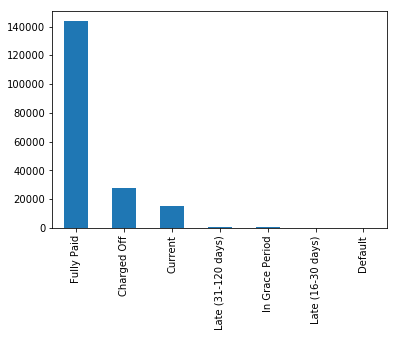

In [6]:
%matplotlib inline

LCdata.loanstatus.value_counts().plot(kind='bar')

print "Converting Charged Off records to Default & Removing records that have Loan Status in Grace Period and Late status"
LCdata.loc[LCdata['loanstatus']=="Charged Off", 'loanstatus'] = 'Default'
data=LCdata[LCdata['loanstatus'].isin(["Fully Paid","Default"])]
print data.loanstatus.value_counts()


IMPUTING THE NULL VALUES IN THE COLUMNS

In [7]:
from sklearn import preprocessing
categorical=data.select_dtypes(include=['object'])
numeric=data.select_dtypes(exclude=['object'])
print(categorical.columns.values)

for name in numeric:
    print(name)
    if pd.isnull(numeric[name]).sum()>0:
        numeric["%s_mi" % (name)]=pd.isnull(numeric[name])
        median=numeric[name].median()
        numeric[name]=numeric[name].apply(lambda x: median if pd.isnull(x) else x)

['homeownership' 'loanstatus' 'purpose' 'title' 'zipcode' 'addrstate'
 'initialliststatus']
loanamnt
fundedamnt
fundedamntinv
term
installment
emplength
annualinc
dti
delinq2yrs
earliestcrline
ficorangelow
ficorangehigh
inqlast6mths
openacc
pubrec
revolbal
revolutil


C:\Users\Ashrita\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Ashrita\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


totalacc
lastficorangehigh
lastficorangelow
collections12mthsexmed
policycode
accnowdelinq
totcollamt
totcurbal
totalrevhilim
accopenpast24mths
avgcurbal
bcopentobuy
bcutil
chargeoffwithin12mths
delinqamnt
mosinoldilacct
mosinoldrevtlop
mosinrcntrevtlop
mosinrcnttl
mortacc
mthssincerecentbc
mthssincerecentinq
numacctsever120pd
numactvbctl
numactvrevtl
numbcsats
numbctl
numiltl
numoprevtl
numrevaccts
numrevtlbalgt0
numsats
numtl120dpd2m
numtl30dpd
numtl90gdpd24m
numtloppast12m
pcttlnvrdlq
percentbcgt75
pubrecbankruptcies
taxliens
tothicredlim
totalbalexmort
totalbclimit
totalilhighcreditlimit


In [8]:
print "Encoding column by column data"

le = preprocessing.LabelEncoder()
for name in categorical:
    print(name)
    categorical[name] = le.fit_transform(categorical[name])

Encoding column by column data
homeownership
loanstatus

C:\Users\Ashrita\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  



purpose
title


C:\Users\Ashrita\Anaconda3\envs\py27\lib\site-packages\numpy\lib\arraysetops.py:216: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


zipcode
addrstate
initialliststatus


Replacing Data columns with column values from Numeric or Categorical respectively

In [9]:
for name in categorical:
    data.loc[:,name]=categorical[name]
    #print(data[name].head(5))
    
    
for name in numeric:
    if name in data.columns.values:
        data.loc[:,name]=numeric[name]
    #print(data[name].head(5))


C:\Users\Ashrita\Anaconda3\envs\py27\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


PERFORM FEATURE SELECTION ON THE DATASET USING RFE METHOD

In [10]:
#Defining X & Y
Y=data.loc[:,'loanstatus']
X=data.loc[:,data.columns!='loanstatus']
model=LogisticRegression()
rfe=RFE(model,None,step=1)
fit=rfe.fit(X,Y)
print("Num Features: %d") % fit.n_features_
print("Selected Features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_

print "Retrieving the subset of data for only the IMP FEATURES"
data_subset = X.iloc[:,fit.get_support(indices=False)]

Num Features: 33
Selected Features: [False False False  True  True  True  True False  True False False False
  True  True  True  True  True  True False False False  True  True False
  True  True False  True False False False False  True False False  True
 False False False  True False False False  True  True  True  True  True
  True  True  True  True  True  True  True False False False  True  True
 False False False False False False False]
Feature Ranking: [12 17  6  1  1  1  1 16  1 14  9  8  1  1  1  1  1  1  3 30 23  1  1 32  1
  1 28  1 27 10 18 20  1 13 15  1 33 11  4  1  2  5 24  1  1  1  1  1  1  1
  1  1  1  1  1 35 29 22  1  1  7 34 31 19 21 25 26]
Retrieving the subset of data for only the IMP FEATURES


In [11]:
#Split the data into 75:25

totaldata = pd.concat([data_subset,data.loanstatus],axis=1)
print("totaldata size:")
print(totaldata.shape)

X = totaldata.loc[:,totaldata.columns!='loanstatus'] 
Y = totaldata.loc[:,'loanstatus']

X_train, X_holdout, Y_train, Y_holdout=train_test_split(X,Y,test_size=0.25,random_state=42)
print X_train.shape
print X_holdout.shape

totaldata size:
(171483, 34)
(128612, 33)
(42871, 33)


In [12]:
############### Naive bayes Gaussian Classifier #####################
from sklearn.naive_bayes import GaussianNB
nbg = GaussianNB()

# set up cv
from sklearn import model_selection
cv = model_selection.KFold(10)

# pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler()),('model', nbg) ])

# Parameters for tuning the model
from sklearn.model_selection import GridSearchCV
optimized_nbg = GridSearchCV(estimator=pipeline, cv=cv, param_grid=dict(), scoring = 'roc_auc', verbose = 1, n_jobs = -1)

#Fitting the model with Grid Search
optimized_nbg.fit(X_train, Y_train)

#Get the best estimator from the grid Search
print "The optimized_nbg.best_score is :{0:.3f}".format(optimized_nbg.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.5s finished


The optimized_nbg.best_score is :0.906


In [13]:
print "Logistic Regression"

lr=LogisticRegression()
# set up cv
from sklearn import model_selection
cv = model_selection.KFold(10)

# pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler()),('model', lr) ])

# Parameters for tuning the model
from sklearn.model_selection import GridSearchCV
optimized_lr = GridSearchCV(estimator=pipeline, cv=cv, param_grid=dict(), scoring = 'roc_auc', verbose = 1, n_jobs = -1)

#Fitting the model with Grid Search
optimized_lr.fit(X_train, Y_train)

#Get the best estimator from the grid Search
print "The optimized_lr.best_score is : {0:.3f}".format(optimized_lr.best_score_)


Logistic Regression
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.8s finished


The optimized_lr.best_score is : 0.936


In [14]:
from sklearn import tree
import graphviz

print "Decision tree"
dt = tree.DecisionTreeClassifier()
# set up cv
cv = model_selection.KFold(10)

# pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler()),('model', dt) ])

# Parameters for tuning the model
optimized_dt = GridSearchCV(estimator=pipeline, cv=cv, param_grid=dict(), scoring = 'roc_auc', verbose = 1, n_jobs = -1)

#Fitting the model with Grid Search
optimized_dt.fit(X_train, Y_train)

#Get the best estimator from the grid Search
print "The optimized_dt.best_score is : {0:.3f}".format(optimized_dt.best_score_)


Decision tree
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.0s finished


The optimized_dt.best_score is : 0.744


In [31]:
from sklearn import neighbors
print "K Nearest neighbor Classfication"

k = np.arange(2)+1
parameters = {'n_neighbors': k}
print parameters
kn=neighbors.KNeighborsClassifier()
# set up cv
cv = model_selection.KFold(10)

# pipeline
#pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler()),('model', kn) ])

# Parameters for tuning the model
optimized_kn = GridSearchCV(estimator=kn, cv=cv, param_grid=dict(parameters), scoring = 'roc_auc', verbose = 1,
                            n_jobs = -1)

#Fitting the model with Grid Search
optimized_kn.fit(X_train, Y_train)

#Get the best estimator from the grid Search
print "The optimized_kn.best_score is : {0:.3f}".format(optimized_kn.best_score_)

K Nearest neighbor Classfication
{'n_neighbors': array([1, 2])}
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.8min finished


The optimized_kn.best_score is : 0.818


TESTING ALL CLASSIFIERS ON HOLD OUT DATA

In [52]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

print "Evaluating Logistic Regression Classifier on the Hold Out Data"

y_pred_lr=optimized_lr.predict(X_holdout)
confusion_matrix_lr = confusion_matrix(Y_holdout, y_pred_lr)
print confusion_matrix_lr
PRF_lr = precision_recall_fscore_support(Y_holdout, y_pred_lr, average='binary')
print "LR Precision:{0:.3f}".format(PRF_lr[0])
print "LR Recall:{0:.3f}".format(PRF_lr[1])
print "LR F1 Score: {0:.3f}".format(PRF_lr[2])

print "Evaluating Gaussian Bayes Classifier on the Hold Out Data"

y_pred_nb=optimized_nbg.predict(X_holdout)
confusion_matrix_nb = confusion_matrix(Y_holdout, y_pred_nb)
print confusion_matrix_nb
PRF_nb = precision_recall_fscore_support(Y_holdout, y_pred_nb, average='binary')
print "Gaussian NB Precision:{0:.3f}".format(PRF_nb[0])
print "Gaussian NB Recall:{0:.3f}".format(PRF_nb[1])
print "Gaussian NB F1 Score: {0:.3f}".format(PRF_nb[2])


print "Evaluating Decision Tree on the Hold Out Data"

y_pred_dt=optimized_dt.predict(X_holdout)
confusion_matrix_dt = confusion_matrix(Y_holdout, y_pred_nb)
print confusion_matrix_dt
PRF_dt = precision_recall_fscore_support(Y_holdout, y_pred_nb, average='binary')
print "Decision Tree Precision:{0:.3f}".format(PRF_dt[0])
print "Decision Tree Recall:{0:.3f}".format(PRF_dt[1])
print "Decision Tree F1 Score: {0:.3f}".format(PRF_dt[2])


print "Evaluating KNN on the Hold Out Data"

y_pred_kn=optimized_kn.predict(X_holdout)
confusion_matrix_kn = confusion_matrix(Y_holdout, y_pred_nb)
print confusion_matrix_kn
PRF_kn = precision_recall_fscore_support(Y_holdout, y_pred_nb, average='binary')
print "Decision Tree Precision:{0:.3f}".format(PRF_kn[0])
print "Decision Tree Recall:{0:.3f}".format(PRF_kn[1])
print "Decision Tree F1 Score: {0:.3f}".format(PRF_kn[2])

Evaluating Logistic Regression Classifier on the Hold Out Data
[[ 3935  3037]
 [ 1577 34322]]
LR Precision:0.919
LR Recall:0.956
LR F1 Score: 0.937
Evaluating Gaussian Bayes Classifier on the Hold Out Data
[[ 4706  2266]
 [ 2910 32989]]
Gaussian NB Precision:0.936
Gaussian NB Recall:0.919
Gaussian NB F1 Score: 0.927
Evaluating Decision Tree on the Hold Out Data
[[ 4706  2266]
 [ 2910 32989]]
Decision Tree Precision:0.936
Decision Tree Recall:0.919
Decision Tree F1 Score: 0.927
Evaluating KNN on the Hold Out Data
[[ 4706  2266]
 [ 2910 32989]]
Decision Tree Precision:0.936
Decision Tree Recall:0.919
Decision Tree F1 Score: 0.927


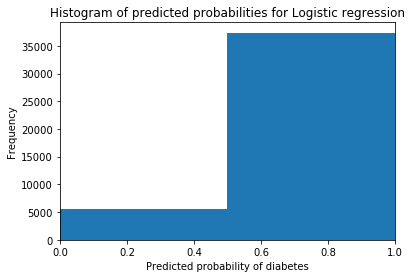

In [47]:
%matplotlib inline

y_pred_lr_prb=optimized_lr.predict_proba(X_holdout)[:, 1]
plt.hist(y_pred_lr_prb, bins=2)
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities for Logistic regression')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')

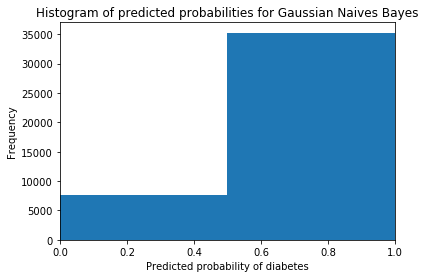

In [49]:
y_pred_nb_prb=optimized_nbg.predict_proba(X_holdout)[:, 1]
plt.hist(y_pred_nb_prb, bins=2)
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities for Gaussian Naives Bayes')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')

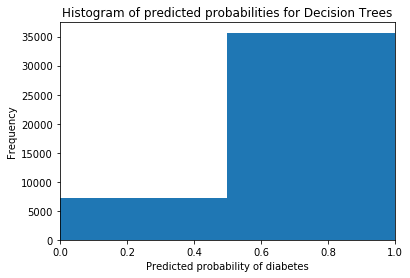

In [50]:
y_pred_dt_prb=optimized_dt.predict_proba(X_holdout)[:, 1]
plt.hist(y_pred_dt_prb, bins=2)
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities for Decision Trees')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')

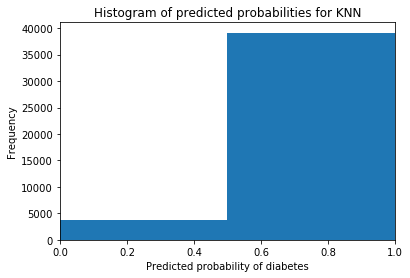

In [51]:
y_pred_kn_prb=optimized_kn.predict_proba(X_holdout)[:, 1]
plt.hist(y_pred_kn_prb, bins=2)
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities for KNN')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')